In [1]:
import pandas as pd
import numpy as np
import random
import DataSets as ds
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import kaplanmeier as km
import warnings
warnings.filterwarnings("ignore")
random.seed(1024)
np.random.seed(1024)

In [2]:
def svm_train_test(train_data, train_y, test_data, classifier_params ={}, verbose=False):
    sm = SMOTE(random_state= 432)
    train_data, train_y = sm.fit_resample(train_data, train_y)
    clf = svm.SVC(kernel = classifier_params["kernel"],probability=True)
    clf = clf.fit(train_data, train_y)

    predictions = clf.predict(test_data)
    probs = clf.predict_proba(test_data)
    probSV = [i[1] for i in probs]
    if verbose:
        print(probSV)
    new_pd = pd.DataFrame(probSV)
    return clf, predictions, new_pd

def evaluate(ytest, preds, yprobs):
    evaluations = {}
    evaluations["aroc"] = roc_auc_score(ytest, yprobs)
    evaluations["precision"] = precision_score(ytest, preds, average="macro")
    evaluations["recall"] = recall_score(ytest, preds, average="macro")
    evaluations["f1"] = f1_score(ytest, preds, average="macro")
    evaluations["precision_true"] = precision_score(ytest, preds, average="binary")
    evaluations["recall_true"] = recall_score(ytest, preds, average="binary")
    evaluations["f1_true"] = f1_score(ytest, preds, average="binary")
    evaluations["precision_false"] = precision_score(ytest, preds, pos_label=-1 ,average="binary")
    evaluations["recall_false"] = recall_score(ytest, preds,pos_label=-1, average="binary")
    evaluations["f1_false"] = f1_score(ytest, preds,pos_label= -1, average="binary")
    evaluations["accuracy"] = accuracy_score(ytest, preds)
    return evaluations


In [3]:
def svm_experiment(additional_info={}):
    train_data, train_y, test_data, test_y, _ , excluded_mutation = ds.transforming_Braun_dataset(additional_info)
#    possible_svm_models = [{"kernel": "linear"},{"kernel":"rbf"},{"kernel":"poly"} ]
    possible_svm_models = [{"kernel":"poly"} ]

    local_results_frames = pd.DataFrame()
    index = 0
    for params in possible_svm_models:
        results = {}
        results["METHOD"] = "Predictor:SVM" + str(params)
        results["Info"] = str(additional_info)
        print("SVM Meta-parameters : " + str(params))

        _,svm_linear_preds, svm_linear_prob = svm_train_test(train_data, train_y, test_data, params)

        results1 = evaluate(test_y, svm_linear_preds, svm_linear_prob)
        if ds.param_check(additional_info, "exclude_mutation"):
            results.update(excluded_mutation.to_dict("records")[0])
        results.update(results1)


        results_frame = pd.DataFrame(results,index = [index])
        if local_results_frames.empty:
            local_results_frames = [results_frame]
        else:
            local_results_frames = [local_results_frames,results_frame]
        local_results_frames = pd.concat(local_results_frames)
        index += 1
    return local_results_frames


def draw_KM_curve_svm_experiment(additional_info={}, svm_params={}):
    train_data, train_y, test_data, test_y, test_pfs = ds.transforming_Braun_dataset(additional_info)
    print("SVM Meta-parameters : " + str(svm_params))
    print("Info :                " + str(additional_info))
    _,svm_linear_preds, svm_linear_prob = svm_train_test(train_data, train_y, test_data, svm_params)

    results = km.fit(test_pfs,test_y,svm_linear_preds)
    km.plot(results)
    return None

In [4]:
weights= {"PS":0.1,"TF":0.1,"CF":0.1,"BP":0.1,"MT":0.1,"GE":0.1}
additional_infos = [
#    {"PRIMARY_TUMOR_ONLY":False,"with_mutations":False,"hotspots":False, "weights":weights,
#     "contig_file":"data/contig_features_reduced2.tsv", "recompute":False},
#    {"PRIMARY_TUMOR_ONLY":False,"with_mutations":True,"hotspots":False, "weights":weights, "contig_file":"data/contig_features_reduced2.tsv"},
#    {"PRIMARY_TUMOR_ONLY":False,"with_mutations":True, "random_contigs":True , "hotspots":True, "weights":weights, "contig_file":"data/contig_features_reduced2.tsv"},
    {"PRIMARY_TUMOR_ONLY":False,"with_mutations":True, "random_contigs":False, "hotspots":False, "weights":weights, "contig_file":"data/contig_features_reduced2.tsv", "HS_features":[]}
    ,
    {"PRIMARY_TUMOR_ONLY":False,"with_mutations":True, "random_contigs":False, "hotspots":True, "weights":weights, "contig_file":"data/contig_features_reduced2.tsv", "HS_features":[]}
    ,
    {"PRIMARY_TUMOR_ONLY":False,"with_mutations":True, "random_contigs":False, "hotspots":True, "weights":weights, "contig_file":"data/contig_features_reduced2.tsv", "HS_features":["spec_count"]}
    ,
    {"PRIMARY_TUMOR_ONLY":False,"with_mutations":True, "random_contigs":False, "hotspots":True, "weights":weights, "contig_file":"data/contig_features_reduced2.tsv", "HS_features":["unique_peptides"]}
    ,
    {"PRIMARY_TUMOR_ONLY":False,"with_mutations":True, "random_contigs":False, "hotspots":True, "weights":weights, "contig_file":"data/contig_features_reduced2.tsv", "HS_features":["n_unique_HLA"]}
    ,
    {"PRIMARY_TUMOR_ONLY":False,"with_mutations":True, "random_contigs":False, "hotspots":True, "weights":weights, "contig_file":"data/contig_features_reduced2.tsv", "HS_features":["unique_peptides","spec_count"]}
    ,
    {"PRIMARY_TUMOR_ONLY":False,"with_mutations":True, "random_contigs":False, "hotspots":True, "weights":weights, "contig_file":"data/contig_features_reduced2.tsv", "HS_features":["n_unique_HLA","unique_peptides","spec_count"]}

]


overall_results = pd.DataFrame()

for additional_info in additional_infos:
    results_frame = svm_experiment(additional_info=additional_info)
    overall_results_frames = [overall_results,results_frame]
    overall_results = pd.concat(overall_results_frames)


overall_results.to_excel("./data/Bruan_MutationExperiments_3.xlsx")
overall_results


Loading reduced dataset
...done



KeyboardInterrupt



In [5]:
weights= {"PS":0.1,"TF":0.1,"CF":0.3,"BP":0.1,"MT":0.1,"GE":0.1}
additional_info = {"PRIMARY_TUMOR_ONLY":False,"with_mutations":True, "random_contigs":False, "hotspots":True, "weights":weights, "contig_file":"data/contig_features_reduced2.tsv","HS_features":[]}




overall_results = pd.DataFrame()
results_frame = svm_experiment(additional_info=additional_info)
overall_results_frames = [overall_results,results_frame]
overall_results = pd.concat(overall_results_frames)


# Intersting Mutation
for chr_to_remove in range(1,170):
    print("excluding mutation: " + str(chr_to_remove))
    additional_info["exclude_mutation"] = chr_to_remove
    results_frame = svm_experiment(additional_info)
    overall_results_frames = [overall_results,results_frame]
    overall_results = pd.concat(overall_results_frames)


overall_results.to_excel("./data/Bruan_MutationExperiments_3_1.xlsx")
overall_results

Loading reduced dataset
...done
MinMax Scaler done
Normalizer done
MinMax Scaler done
Normalizer done
SVM Meta-parameters : {'kernel': 'poly'}
excluding mutation: 0
Loading reduced dataset
...done
MinMax Scaler done
Normalizer done
MinMax Scaler done
Normalizer done
SVM Meta-parameters : {'kernel': 'poly'}
excluding mutation: 1
Loading reduced dataset
...done
MinMax Scaler done
Normalizer done
MinMax Scaler done
Normalizer done
SVM Meta-parameters : {'kernel': 'poly'}


,METHOD,Info,aroc,precision,recall,f1,precision_true,recall_true,f1_true,precision_false,recall_false,f1_false,accuracy,Chromosome,Start_position,End_position,Count
0,Predictor:SVM{'kernel': 'poly'},"{'PRIMARY_TUMOR_ONLY': False, 'with_mutations'...",0.657895,0.644737,0.644737,0.644737,0.526316,0.526316,0.526316,0.763158,0.763158,0.763158,0.684211,NaN,NaN,NaN,NaN
0,Predictor:SVM{'kernel': 'poly'},"{'PRIMARY_TUMOR_ONLY': False, 'with_mutations'...",0.657895,0.644737,0.644737,0.644737,0.526316,0.526316,0.526316,0.763158,0.763158,0.763158,0.684211,NaN,NaN,NaN,NaN
0,Predictor:SVM{'kernel': 'poly'},"{'PRIMARY_TUMOR_ONLY': False, 'with_mutations'...",0.596953,0.528963,0.526316,0.525859,0.375000,0.315789,0.342857,0.682927,0.736842,0.708861,0.596491,chr5,43120013.0,43120013.0,86.0


Loading reduced dataset
...done
MinMax Scaler done
Normalizer done
MinMax Scaler done
Normalizer done
SVM Meta-parameters : {'kernel': 'rbf'}
Info :                {'PRIMARY_TUMOR_ONLY': False, 'with_mutations': False, 'hotspots': False, 'weights': {'PS': 0.1, 'TF': 0.1, 'CF': 0.3, 'BP': 0.1, 'MT': 0.1, 'GE': 0.1}, 'contig_file': 'data/Braun_mutations_hg38_with_epitope_contigs.tsv'}


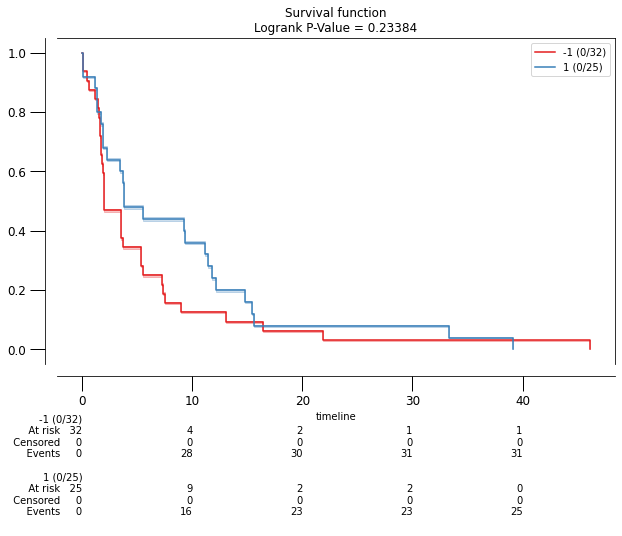

In [5]:
draw_KM_curve_svm_experiment(svm_params={'kernel':'rbf'},additional_info={"PRIMARY_TUMOR_ONLY":False,"with_mutations":False,"hotspots":False, "weights":weights, "contig_file":"data/Braun_mutations_hg38_with_epitope_contigs.tsv"})

Loading reduced dataset
...done
MinMax Scaler done of the HS features
MinMax Scaler done
Normalizer done
MinMax Scaler done
Normalizer done
SVM Meta-parameters : {'kernel': 'poly'}
Info :                {'PRIMARY_TUMOR_ONLY': False, 'with_mutations': True, 'hotspots': True, 'weights': {'PS': 0.1, 'TF': 0.1, 'CF': 0.1, 'BP': 0.1, 'MT': 0.1, 'GE': 0.1}, 'contig_file': 'data/contig_features_reduced2.tsv', 'HS_features': ['n_unique_HLA']}


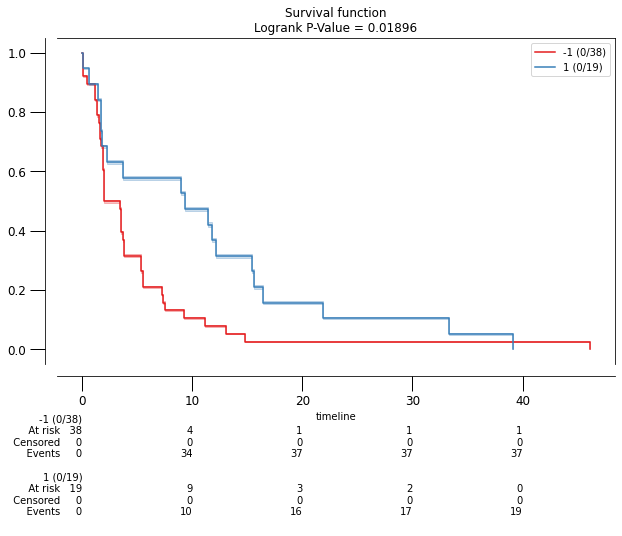

In [10]:
#weights = {"PS": 0.1, "TF": 0.1, "CF": 0.1, "BP": 0.1, "MT": 0.1, "GE": 0.1}
draw_KM_curve_svm_experiment(svm_params={'kernel': 'poly'},
                             additional_info={"PRIMARY_TUMOR_ONLY": False, "with_mutations": True, "hotspots": True,
                                              "weights": weights, "contig_file":"data/contig_features_reduced2.tsv", "HS_features":["n_unique_HLA"]})

Loading reduced dataset
...done
MinMax Scaler done
Normalizer done
MinMax Scaler done
Normalizer done
SVM Meta-parameters : {'kernel': 'poly'}
Info :                {'PRIMARY_TUMOR_ONLY': False, 'with_mutations': True, 'hotspots': True, 'weights': {'PS': 0.1, 'TF': 0.1, 'CF': 0.3, 'BP': 0.1, 'MT': 0.1, 'GE': 0.1}, 'contig_file': 'data/contig_features_reduced2.tsv', 'HS_features': ['n_unique_HLA', 'unique_peptides', 'spec_count']}


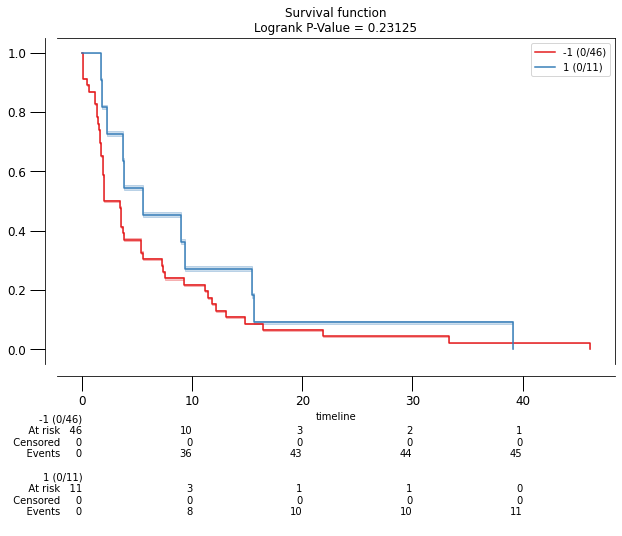

In [6]:
draw_KM_curve_svm_experiment(svm_params={'kernel': 'poly'},
                             additional_info={"PRIMARY_TUMOR_ONLY": False, "with_mutations": True, "hotspots": True,
                                              "weights": weights, "contig_file":"data/contig_features_reduced2.tsv", "HS_features":["n_unique_HLA","unique_peptides","spec_count"]})